# OpenCV, Computer Vision :  Creating a playing card dataset

## Setup

In [1]:
import numpy as np
import pandas as pd 
import cv2
import sys
from glob import glob
import pickle
import os
import matplotlib.image as mpimg
import matplotlib.patches as patches
from matplotlib import pyplot as plt
import random
from PIL import Image

In [2]:
CARD_PATH = "./AS.jpg"

In [3]:
card = cv2.imread(CARD_PATH)

cardW=56
cardH=87
cornerXmin=2.7
cornerXmax=10.8
cornerYmin=2.8
cornerYmax=19.3

In [4]:
# Variables
card_suits=['s','h','d','c']
card_values=['A','K','Q','J','10','9','8','7','6','5','4','3','2']

zoom=4
cardW*=zoom
cardH*=zoom
cornerXmin=int(cornerXmin*zoom)
cornerXmax=int(cornerXmax*zoom)
cornerYmin=int(cornerYmin*zoom)
cornerYmax=int(cornerYmax*zoom)


refCard=np.array([[0,0],[cardW,0],[cardW,cardH],[0,cardH]],dtype=np.float32)
refCardRot=np.array([[cardW,0],[cardW,cardH],[0,cardH],[0,0]],dtype=np.float32)

#Box top left
TopLeftCorner=np.array([[cornerXmin,cornerYmin],[cornerXmax,cornerYmin],[cornerXmax,cornerYmax],[cornerXmin,cornerYmax]],dtype=np.float32)
#box bottom right
BottomRightCorner=np.array([[cardW-cornerXmax,cardH-cornerYmax],[cardW-cornerXmin,cardH-cornerYmax],[cardW-cornerXmin,cardH-cornerYmin],[cardW-cornerXmax,cardH-cornerYmin]],dtype=np.float32)

refCorners=np.array([TopLeftCorner,BottomRightCorner])
imgW=1080
imgH=1080


## Downloading and adding to variable a background dataset

In [5]:
#!wget https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz --no-check-certificate

In [6]:
#!tar xf dtd-r1.0.1.tar.gz

In [18]:
background_dir="dtd/images/"
background_images=[]
i=0
for subdir in glob(background_dir+"/*"):
    for f in glob(subdir+"/*.jpg"):
        i+=1
        background_images.append(mpimg.imread(f))
        
pickle.dump(background_images,open("./backgrounds.pck",'wb'))

In [5]:
#!del -r dtd
#!del dtd-r1.0.1.tar.gz

In [7]:
#Loade pickle backgound file into variable
class Backgrounds():
    def __init__(self,backgrounds_pck_fn="./backgrounds.pck"):
        self._images=pickle.load(open(backgrounds_pck_fn,"rb"))
        self._nb_images=len(self._images)
    def get_random(self, display=False):
        bg=self._images[random.randint(0,self._nb_images-1)]
        if display: plt.imshow(bg)
        return bg

backgrounds = Backgrounds()

## Extraction of the cards
### Define a mask
=> process of combining an image with a background to create the appearance of partial or full transparency

Why ?
- To clean the border of the card
- To make the border transparent 

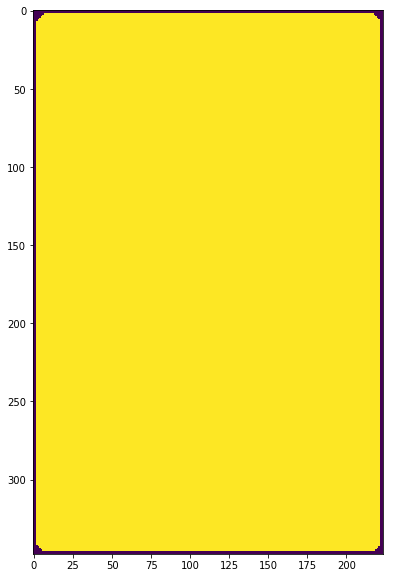

In [8]:
bord_size=2 #bord_size alpha=0
mask=np.ones((cardH,cardW),dtype=np.uint8)*255
cv2.rectangle(mask,(0,0),(cardW-1,cardH-1),0,bord_size)
cv2.line(mask,(bord_size*3,0),(0,bord_size*3),0,bord_size)
cv2.line(mask,(cardW-bord_size*3,0),(cardW,bord_size*3),0,bord_size)
cv2.line(mask,(0,cardH-bord_size*3),(bord_size*3,cardH),0,bord_size)
cv2.line(mask,(cardW-bord_size*3,cardH),(cardW,cardH-bord_size*3),0,bord_size)
plt.figure(figsize=(10,10))
plt.imshow(mask)

### Extract a card from img
blur : https://www.pyimagesearch.com/2015/09/07/blur-detection-with-opencv/

In [9]:
#get card function
def get_card(img, output, min_focus=100):
    #blur detection on the image by laplacian method
    focus = cv2.Laplacian(img, cv2.CV_64F).var()
    if focus < min_focus: 
        return False,None
    
    # Convert in gray color and noise reducing by bilat filtering
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)
    # Edge extraction
    edge = cv2.Canny(gray,50,240)
            
    # Find the contours in the edged image 
    cnts, hierar = cv2.findContours(edge.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = sorted(cnts, key = cv2.contourArea, reverse = True)[0] #largest area cnt is the card
      
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    areaCnt = cv2.contourArea(cnt)
    areaBox = cv2.contourArea(box)
    valid = areaCnt / areaBox > 0.95
    extr_img=None
    
    if valid:
        # We want transform the zone inside the contour into the reference rectangle of dimensions (cardW,cardH)
        ((xr,yr),(wr,hr),thetar) = rect
        # Determine 'Mp' the transformation that transforms 'box' into the reference rectangle
        if wr > hr:
            Mp = cv2.getPerspectiveTransform(np.float32(box),refCard)
        else: 
            Mp = cv2.getPerspectiveTransform(np.float32(box),refCardRot)
        # Determine the warped image by applying the transformation to the image
        extr_img = cv2.warpPerspective(img,Mp,(cardW,cardH))
        # Add alpha layer
        extr_img = cv2.cvtColor(extr_img,cv2.COLOR_BGR2BGRA)
        
        # Shape of 'cnt' is (n,1,2), type=int with n = number of points
        # We reshape into (1,n,2), type=float32, before feeding to perspectiveTransform
        cnta = cnt.reshape(1,-1,2).astype(np.float32)
        # Apply the transformation 'Mp' to the contour
        cntwarp = cv2.perspectiveTransform(cnta,Mp)
        cntwarp = cntwarp.astype(np.int)
        
        # We build the alpha channel so that we have transparency on the
        # external border of the card
        alphachannel = np.zeros(extr_img.shape[:2],dtype=np.uint8)
        cv2.drawContours(alphachannel,cntwarp,0,255,-1)
        
        alphachannel = cv2.bitwise_and(alphachannel,mask)
        
        # Add the alphachannel to the warped image
        extr_img[:,:,3] = alphachannel

        # Save the image to file
        if output is not None:
            cv2.imwrite(output,extr_img)
        
    return valid, extr_img

In [ ]:
img = cv2.imread(CARD_PATH)
valid, card_extracted = get_card(img,"./AS_EXTRACTED.jpg")
print(valid)

In [11]:
def get_card_videos(video_path, output_dir="test/As", keep_ratio=0.5, min_focus=100):
    if not os.path.isfile(video_path):
        return -1,[]
    if output_dir is not None and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    captured_vid = cv2.VideoCapture(video_path)
    frame_nb=0
    imgs_list=[]
    
    while True:
        ret, img= captured_vid.read()
        if not ret: break
        # Work on every 'keep_ratio' frames
        if frame_nb%keep_ratio==0:
            if output_dir is not None:
                bname = "%09d"%random.randint(0,999999999)
                fnames = []
                fname = output_dir + "/" + bname + ".png"
                if not os.path.isfile(fname):
                    fnames.append(fname)
                if len(fnames) == len("png"): break
                    
                if len(fnames) == 1:
                    output_fn = fnames[0]
                else:
                    output_fn = fnames
            else:
                output_fn=None
                
            valid, card_img = get_card(img,output_fn,min_focus=min_focus)
            if valid:
                imgs_list.append(card_img)
        frame_nb+=1
    return imgs_list

104


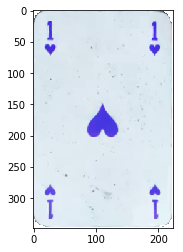

In [95]:
# Here create your whole dataset of cards
imgs = get_card_videos("./AH.mp4",output_dir="data/cards/Ah")
print(len(imgs))
plt.imshow(imgs[0])

#50 img per card ~~

### Get corner sign of card
Idea here is to labellised each card now
Step 1 : check both corner top right and bottom left to match the entire sign

In [12]:
def get_random(card=None):
    if card:
        list_images = glob("data/cards"+"/"+card+"/*.png")
    else:
        list_images = glob("data/cards"+"/*/*.png")
    choosen_img = random.choice(list_images)
    return cv2.imread(choosen_img,cv2.IMREAD_UNCHANGED)

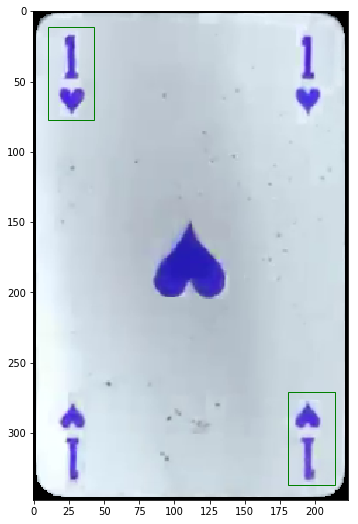

In [97]:
list_images = glob("data/cards"+"/*/*.png")
choosen_img = random.choice(list_images)
img_polygon = get_random()

polygons = [TopLeftCorner,BottomRightCorner]
nb_channels = img_polygon.shape[2]
if nb_channels==4:
    img=cv2.cvtColor(img,cv2.COLOR_BGRA2RGBA)
else:
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)   
    
fig,ax=plt.subplots(figsize=(9,9))
ax.set_facecolor((0,0,0))
ax.imshow(img_polygon)    

for p in polygons:
    if len(p.shape) == 3:
        p = p.reshape(-1,2)
    patch = patches.Polygon(p,linewidth = 1, edgecolor = 'g', facecolor = 'none')
    ax.add_patch(patch)    

plt.imshow(img_polygon)


Step 2 : define the convex envelope of the sign by using opencv findCountours functions and aproxx
We have to grayscale our image and select the sign zone we delimitered before
After a dilate, can find countours easily

In [13]:
def find_envelope(img, corner):
    corner = corner.astype(np.int)

    x1 = int(corner[0][0])
    y1 = int(corner[0][1])
    x2 = int(corner[2][0])
    y2 = int(corner[2][1])
    w = x2-x1
    h = y2-y1
    sign = img[y1:y2,x1:x2].copy()
    
    gray=cv2.cvtColor(sign,cv2.COLOR_BGR2GRAY)
    edges=cv2.Canny(gray,30,200)
    edges = cv2.dilate(edges, np.ones((3,3),np.uint8),iterations=1)
    contours,_ = cv2.findContours(edges.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    min_area = 10 # We will reject contours with small area. TWEAK, 'zoom' dependant
    min_solidity = 0.1 # Reject contours with a low solidity. TWEAK
    cnt = None 
    no_match = False
    for c in contours:
        area = cv2.contourArea(c)
        envlp = cv2.convexHull(c)
        evlp_area = cv2.contourArea(envlp)
        solidity = float(area) / evlp_area
        # Set center gravity to considere center of the zone as asumption
        M=cv2.moments(c)
        cx=int(M['m10']/M['m00'])
        cy=int(M['m01']/M['m00'])
        
        if area >= min_area and abs(w/2-cx)<w*0.3 and abs(h/2-cy)<h*0.4 and solidity>min_solidity:
            if cnt is None:
                cnt = c
            else:
                cnt=np.concatenate((cnt,c))               
                
    if cnt is not None:
        envlp=cv2.convexHull(cnt)
        envlp_area=cv2.contourArea(envlp)        
        min_envlp_area=700 # TWEAK, deck and 'zoom' dependant
        max_envlp_area=2000 # TWEAK, deck and 'zoom' dependant
        if envlp_area < min_envlp_area or envlp_area > max_envlp_area: 
            no_match=True
        envlp_img = envlp + corner[0]
            
    if no_match == True:
        return None
    
    return envlp_img

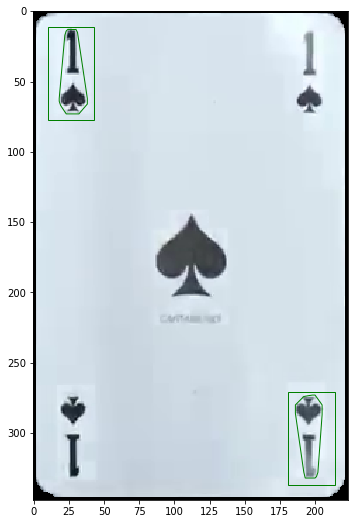

In [162]:
img_convex = get_random("As")
top_left_envlp = find_envelope(img_convex, TopLeftCorner)
bottom_right_envlp = find_envelope(img_convex, BottomRightCorner)

polygons = [TopLeftCorner, BottomRightCorner, top_left_envlp, bottom_right_envlp]
nb_channels = img_convex.shape[2]
if nb_channels==4:
    img=cv2.cvtColor(img,cv2.COLOR_BGRA2RGBA)
else:
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)   
    
fig,ax=plt.subplots(figsize=(9,9))
ax.set_facecolor((0,0,0))
ax.imshow(img_convex)    

for p in polygons:
    if len(p.shape) == 3:
        p = p.reshape(-1,2)
    patch = patches.Polygon(p, linewidth = 1, edgecolor = 'g', facecolor = 'none')
    ax.add_patch(patch)    

plt.imshow(img_convex)


Step 3 : Load dataset and calcul convex envlp for each

In [164]:
# Load into Pickle file as for Background for generating hand scenes ONCE

imgs_dir="data/cards/"

cards={}

for suit in card_suits:
    for value in card_values:
        card_name = value + suit        
        card_dir = imgs_dir + "/" + card_name
        cards[card_name]=[]
        
        for f in glob(card_dir+"/*.png"):
            img = cv2.imread(f,cv2.IMREAD_UNCHANGED)
            envlp_top_right = find_envelope(img,TopLeftCorner) 
            envlp_bottom_left = find_envelope(img,BottomRightCorner) 
            img = cv2.cvtColor(img,cv2.COLOR_BGRA2RGBA)
            
            cards[card_name].append((img,envlp_top_right,envlp_bottom_left))

pickle.dump(cards,open("cards.pck",'wb'))

In [14]:
class Cards():
    def __init__(self,cards_pck="cards.pck"):
        self._cards=pickle.load(open(cards_pck,'rb'))
        # self._cards is a dictionary where keys are card names (ex:'Kc') and values are lists of (img,hullHL,hullLR) 
        self._nb_cards_by_value={k:len(self._cards[k]) for k in self._cards}
        print("Nb of cards loaded per name :", self._nb_cards_by_value)
        
    def get_random(self, card_name=None, display=False):
        if card_name is None:
            card_name = random.choice(list(self._cards.keys()))
        card,hull1,hull2=self._cards[card_name][random.randint(0,self._nb_cards_by_value[card_name]-1)]
        if display:
            if display: display_img(card,[hull1,hull2],"rgb")
        return card,card_name,hull1,hull2
    
cards = Cards()

Nb of cards loaded per name : {'As': 49, 'Ks': 52, 'Qs': 53, 'Js': 57, '10s': 63, '9s': 53, '8s': 54, '7s': 31, '6s': 35, '5s': 36, '4s': 38, '3s': 42, '2s': 22, 'Ah': 56, 'Kh': 40, 'Qh': 63, 'Jh': 39, '10h': 45, '9h': 63, '8h': 61, '7h': 37, '6h': 29, '5h': 36, '4h': 33, '3h': 56, '2h': 42, 'Ad': 40, 'Kd': 42, 'Qd': 47, 'Jd': 29, '10d': 51, '9d': 67, '8d': 28, '7d': 74, '6d': 23, '5d': 44, '4d': 37, '3d': 36, '2d': 42, 'Ac': 54, 'Kc': 66, 'Qc': 33, 'Jc': 35, '10c': 34, '9c': 33, '8c': 39, '7c': 44, '6c': 64, '5c': 60, '4c': 43, '3c': 44, '2c': 50}


## Generate Hand Scenes and Save PASCAL VOC labbelized

Using imgaug



In [17]:

xml_body_1="""<annotation>
        <folder>FOLDER</folder>
        <filename>{FILENAME}</filename>
        <path>{PATH}</path>
        <source>
                <database>Unknown</database>
        </source>
        <size>
                <width>{WIDTH}</width>
                <height>{HEIGHT}</height>
                <depth>3</depth>
        </size>
"""
xml_object=""" <object>
                <name>{CLASS}</name>
                <pose>Unspecified</pose>
                <truncated>0</truncated>
                <difficult>0</difficult>
                <bndbox>
                        <xmin>{XMIN}</xmin>
                        <ymin>{YMIN}</ymin>
                        <xmax>{XMAX}</xmax>
                        <ymax>{YMAX}</ymax>
                </bndbox>
        </object>
"""
xml_body_2="""</annotation>        
"""

def create_voc_xml(xml_file, img_file,listbba,display=False):
    with open(xml_file,"w") as f:
        f.write(xml_body_1.format(**{'FILENAME':os.path.basename(img_file), 'PATH':img_file,'WIDTH':imgW,'HEIGHT':imgH}))
        for bba in listbba:            
            f.write(xml_object.format(**{'CLASS':bba.classname,'XMIN':bba.x1,'YMIN':bba.y1,'XMAX':bba.x2,'YMAX':bba.y2}))
        f.write(xml_body_2)
        if display: print("New xml",xml_file)

In [16]:
import imgaug as ia
from imgaug import augmenters as iaa
from shapely.geometry import Polygon
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage


In [18]:

decalX=int((imgW-cardW)/2 - 100)
decalY=int((imgH-cardH)/2 - 300)

decalX2=int((imgW-cardW)/2)
decalY2=int((imgH-cardH)/2)

scaleBg=iaa.Resize({"height": imgH, "width": imgW})

rotation = {
    1: [random.randint(-100,-85), 0, 0],
    2: [random.randint(-70,-60), 50, 80],
    3: [random.randint(-45,-32), 70, 160],
    4: [random.randint(-25,-15), 70, 230],
    5: [random.randint(-7,5), 20, 280],
    6: [random.randint(20,25),-40, 310],
    7: [random.randint(38,45),-70, 330],
    8: [random.randint(58,66),-150, 330]
}

def get_rotation(nb):
    rota = rotation[nb+1]
    seq = iaa.Sequential([
        iaa.Affine(
            translate_px={"x":rota[1], "y": rota[2]},
            rotate=rota[0]
        ) 
    ])
    return seq


def get_simple_rotation(nb):
    rota = rotation[nb+1]
    seq = iaa.Sequential([
        iaa.Affine(
            scale=(0.9, 1.4)
        ),
        iaa.PerspectiveTransform(scale=(0.01, 0.90))
    ])
    
    return seq.to_deterministic()


# imgaug keypoints of the bounding box of a whole card
cardKP = ia.KeypointsOnImage([
    ia.Keypoint(x=decalX,y=decalY),
    ia.Keypoint(x=decalX+cardW,y=decalY),   
    ia.Keypoint(x=decalX+cardW,y=decalY+cardH),
    ia.Keypoint(x=decalX,y=decalY+cardH)
    ], shape=(imgH,imgW,3))

def transform_boudingboxes(image, list_kps):
    while True:
        list_bbs = [kps_to_BB(list_kps[1]),kps_to_BB(list_kps[2])]
        valid=True
        for bb in list_bbs:
            if bb is None or int(round(bb.x2)) >= imgW or int(round(bb.y2)) >= imgH or int(bb.x1)<=0 or int(bb.y1)<=0:
                valid = False
                break
        if valid: break
        else:
            img_aug = None
            break
    return image, list_kps, list_bbs        

def place_card(image, list_kps, seq):
    # place a card with an applied "seq" to image and keypoints
    while True:
        myseq = seq
        # Augment image, keypoints and bbs 
        img_aug = myseq.augment_images([image])[0]
        list_kps_aug = [myseq.augment_keypoints([kp])[0] for kp in list_kps]
        list_bbs = [kps_to_BB(list_kps_aug[1]),kps_to_BB(list_kps_aug[2])]
        valid=True
        # Check the card bounding box stays inside the image
        for bb in list_bbs:
            if bb is None or int(round(bb.x2)) >= imgW or int(round(bb.y2)) >= imgH or int(bb.x1)<=0 or int(bb.y1)<=0:
                valid=False
                break
        if valid: break
        else:
            img_aug = None
            break
                
    return img_aug,list_kps_aug,list_bbs


def warp_img(image, list_kps, seq):
    # place a card with an applied "seq" to image and keypoints
    while True:
        myseq = seq
        # Augment image, keypoints and bbs 
        list_bbs = [kps_to_BB(list_kps[0]),kps_to_BB(list_kps[1])]
        img_aug = myseq.augment_images([image])[0]        
        list_bbs_on_img = BoundingBoxesOnImage(list_bbs, shape=(348, 228, 4))
        
        img_aug, list_kps_aug, list_bbs = seq(image=image, keypoints=list_kps, bounding_boxes=list_bbs_on_img)
        
        break
    return img_aug,list_kps_aug,list_bbs

def kps_to_BB(kps):
    """
        Determine imgaug bounding box from imgaug keypoints
    """
    extend=3 # To make the bounding box a little bit bigger
    kpsx=[kp.x for kp in kps.keypoints]
    minx=max(0,int(min(kpsx)-extend))
    maxx=min(imgW,int(max(kpsx)+extend))
    kpsy=[kp.y for kp in kps.keypoints]
    miny=max(0,int(min(kpsy)-extend))
    maxy=min(imgH,int(max(kpsy)+extend))
    if minx==maxx or miny==maxy:
        return None
    else:
        return ia.BoundingBox(x1=minx,y1=miny,x2=maxx,y2=maxy)

class BBA:  # Bounding box + annotations
    def __init__(self,bb,classname):      
        self.x1=int(round(bb.x1))
        self.y1=int(round(bb.y1))
        self.x2=int(round(bb.x2))
        self.y2=int(round(bb.y2))
        self.classname=classname


In [19]:
class Hand:
    def __init__(self, background, imgs = [], names = [], tlEnvlp = [], brEnvlp = [], isHand=True):
        self.names = names
        self.listbba = []
        self.mask = imgs.copy()
        self.imgs = imgs.copy()
        self.lkps = imgs.copy()
        self.bbs = imgs.copy()
        self.background = scaleBg.augment_image(background)
        if isHand:
            self.createHand(background, imgs, names, tlEnvlp, brEnvlp)
        else:
            self.createSimpleCards(background, imgs, names, tlEnvlp, brEnvlp)
        
    def createHand(self, background, imgs, names, tlEnvlp, brEnvlp):
        kpsa = [] #imgaug keypoints to shapely Polygon
        kpsb = []
        for idx, img in enumerate(imgs):
            kpsai=[ia.Keypoint(x = p[0]+decalX, y = p[1]+decalY) for p in tlEnvlp[idx].reshape(-1,2)]
            kpsai=ia.KeypointsOnImage(kpsai, shape=(imgH,imgW,3))
            kpsbi=[ia.Keypoint(x = p[0]+decalX, y = p[1]+decalY) for p in brEnvlp[idx].reshape(-1,2)]
            kpsbi=ia.KeypointsOnImage(kpsbi, shape=(imgH,imgW,3))
            kpsa.append(kpsai)
            kpsb.append(kpsbi)        
            
        for i in range(len(imgs)):
            self.imgs[i] = np.zeros((imgH,imgW,4),dtype=np.uint8)
            if imgs[i].shape == (348,224,4):
                self.imgs[i][decalY:decalY+cardH,decalX:decalX+cardW,:] = imgs[i] 
            else:
                self.imgs[i][decalY:decalY+cardH,decalX:decalX+cardW + 4,:] = imgs[i]  
        
        for i in range(len(imgs)):
            self.imgs[i], self.lkps[i], self.bbs[i] = place_card(self.imgs[i], [cardKP, kpsa[i], kpsb[i]], get_rotation(i))
        
        for idx, img in enumerate(self.imgs):
            self.listbba.append(BBA(self.bbs[idx][0],self.names[idx]))
        self.listbba.append(BBA(self.bbs[len(imgs)-1][1],self.names[len(imgs)-1]))           
        
        for i in range(len(imgs)):
            if i == 0:     
                mask = self.imgs[i][:,:,3]
                self.mask[i] = np.stack([mask]*3,-1)
                self.final = np.where(self.mask[i], self.imgs[i][:,:,0:3], self.background)            
            else:      
                mask = self.imgs[i][:,:,3]
                self.mask[i] = np.stack([mask]*3,-1)
                self.final = np.where(self.mask[i], self.imgs[i][:,:,0:3], self.final)
                
    def createSimpleCards(self, background, imgs, names, tlEnvlp, brEnvlp):
        kpsa = [] #imgaug keypoints to shapely Polygon
        kpsb = []
        for idx, img in enumerate(imgs):
            kpsai=[ia.Keypoint(x = p[0]+decalX2, y = p[1]+decalY2) for p in tlEnvlp[idx].reshape(-1,2)]
            kpsai=ia.KeypointsOnImage(kpsai, shape=(imgH,imgW,3))
            kpsbi=[ia.Keypoint(x = p[0]+decalX2, y = p[1]+decalY2) for p in brEnvlp[idx].reshape(-1,2)]
            kpsbi=ia.KeypointsOnImage(kpsbi, shape=(imgH,imgW,3))
            kpsa.append(kpsai)
            kpsb.append(kpsbi)        
            
        for i in range(len(imgs)):
            self.imgs[i] = np.zeros((imgH,imgW,4),dtype=np.uint8)
            if imgs[i].shape == (348,224,4):
                self.imgs[i][decalY2:decalY2+cardH,decalX2:decalX2+cardW,:] = imgs[i] 
            else:
                self.imgs[i][decalY2:decalY2+cardH,decalX2:decalX2+cardW + 4,:] = imgs[i]  
        
        for i in range(len(imgs)):
            self.imgs[i], self.lkps[i], self.bbs[i] = warp_img(self.imgs[i], [cardKP, kpsa[i], kpsb[i]], get_simple_rotation(i))      
        
        for i in range(len(imgs)):
            if i == 0:     
                mask = self.imgs[i][:,:,3]
                self.mask[i] = np.stack([mask]*3,-1)
                self.final = np.where(self.mask[i], self.imgs[i][:,:,0:3], self.background)            
            else:      
                mask = self.imgs[i][:,:,3]
                self.mask[i] = np.stack([mask]*3,-1)
                self.final = np.where(self.mask[i], self.imgs[i][:,:,0:3], self.final)                
                
                
    

    def display(self):
        fig,ax=plt.subplots(1,figsize=(8,8))
        ax.imshow(self.final)
        for bb in self.listbba:
            rect = patches.Rectangle((bb.x1,bb.y1), bb.x2-bb.x1,bb.y2-bb.y1, linewidth=1, edgecolor='b', facecolor='none')
            ax.add_patch(rect)     
            
    def res(self):
        return self.final
    
    def write_files(self,save_dir,display=False):
        bname = "%09d"%random.randint(0,999999999)
        jpg_fn, xml_fn=[save_dir+"/"+bname+".jpg",save_dir+"/"+bname+".xml"]
        plt.imsave(jpg_fn,self.final)
        if display: print("New image saved in",jpg_fn)
        create_voc_xml(xml_fn,jpg_fn, self.listbba,display=display)    
        

['6d', 'Ks', 'Kc', '5c', '3s', '9c', '3c']


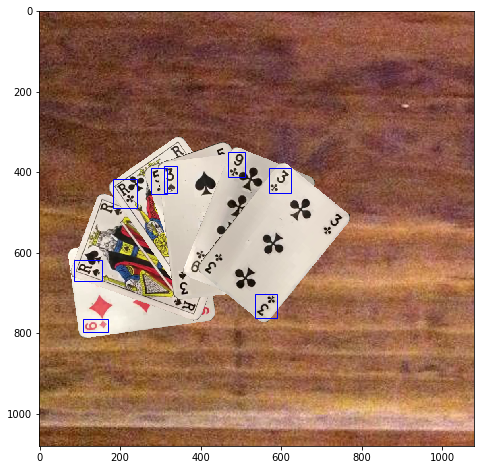

In [20]:
# Test generation

bg = backgrounds.get_random()
imgs = []
names = []
tl_envlp = []
br_envlp = []
#QS KS 
list_keys = list(cards._cards.keys())

nb_c = random.randint(6,8)

for i in range(nb_c):
    rand_name = random.choice(list_keys)
    img, name, tl_envlpone, br_envlpone = cards.get_random(card_name=rand_name)
    imgs.append(img)
    names.append(name)
    tl_envlp.append(tl_envlpone)
    br_envlp.append(br_envlpone)
print(names)

my_hand = Hand(bg, imgs, names, tl_envlp, br_envlp)
my_hand.display()

Next step : Create a function that  generate nb_g hands with xml correspondant to generate dataset

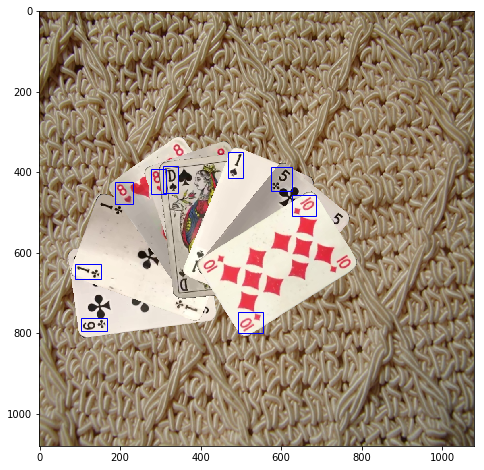

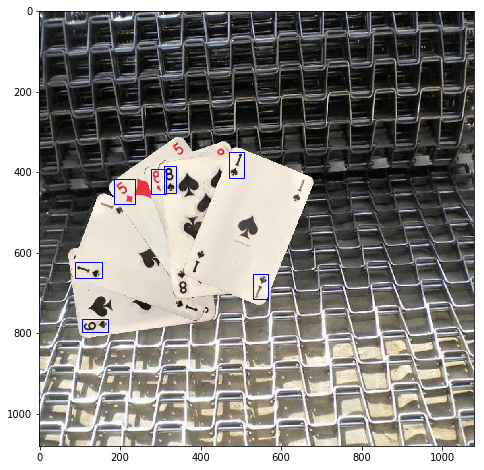

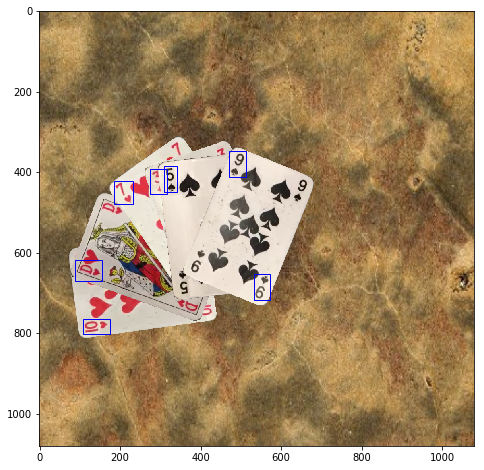

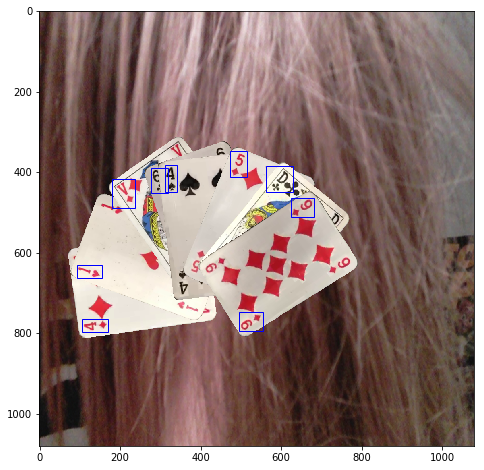

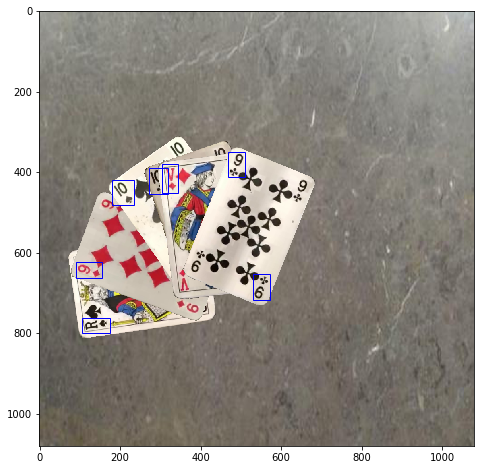

In [22]:
#Load hand images to folder dataset

nb_g = 5
save_dir="data/dataset"

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

    
list_keys = list(cards._cards.keys())    
    
    
    
for e in range(nb_g):
    bg = backgrounds.get_random()
    imgs = []
    names = []
    tl_envlp = []
    br_envlp = []
    nb_c = random.randint(6,8)
    for i in range(nb_c):
        rand_name = random.choice(list_keys)
        img, name, tl_envlpone, br_envlpone = cards.get_random(card_name=rand_name)
        imgs.append(img)
        names.append(name)
        tl_envlp.append(tl_envlpone)
        br_envlp.append(br_envlpone)
    my_hand = Hand(bg, imgs, names, tl_envlp, br_envlp)
    my_hand.write_files(save_dir)
    my_hand.display()

## Test : Aumentation Image in order to diversify dataset icons

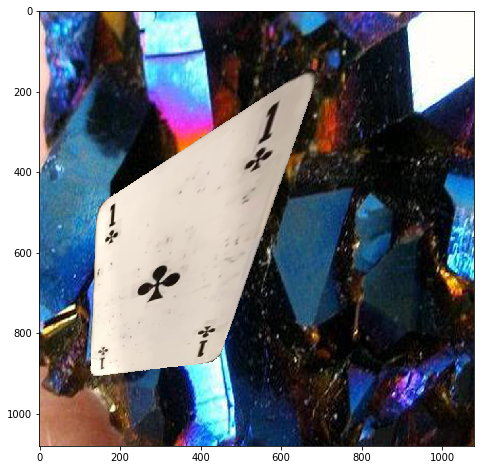

In [487]:
# Test generation

bg = backgrounds.get_random()
imgs = []
names = []
tl_envlp = []
br_envlp = []
#QS KS 
list_keys = list(cards._cards.keys())

nb_c = random.randint(6,8)

for i in range(1):
    rand_name = random.choice(list_keys)
    img, name, tl_envlpone, br_envlpone = cards.get_random(card_name=rand_name)
    imgs.append(img)
    names.append(name)
    tl_envlp.append(tl_envlpone)
    br_envlp.append(br_envlpone)

my_hand = Hand(bg, imgs, names, tl_envlp, br_envlp, False)
my_hand.display()